In [1]:
import addfips
import requests
import matplotlib.pyplot as plt
from IPython.display import Image
import folium
import pickle
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster
import pyproj
import collections

%matplotlib inline

#### Bring in the counties shapefile

In [2]:
counties = gpd.read_file('../data/counties/tncounty.shp')
print(counties.crs)
counties.head()

epsg:2274


,OBJECTID,NAME,KEY,SHAPE_AREA,SHAPE_LEN,geometry
0,76,Chester,47023,8.049024e+09,520461.080124,"POLYGON ((1137985.762 344601.643, 1137965.070 ..."
1,77,Wayne,47181,2.050741e+10,666520.678598,"POLYGON ((1365052.057 391716.806, 1365746.554 ..."
2,78,Tipton,47167,1.319125e+10,865093.887634,"MULTIPOLYGON (((886814.330 400456.525, 886774...."
3,79,Hamilton,47065,1.604776e+10,652926.001078,"POLYGON ((2274954.438 239788.911, 2274090.610 ..."
4,80,Stewart,47161,1.375003e+10,490090.336180,"POLYGON ((1382472.783 743972.302, 1382445.171 ..."


In [3]:
counties.crs

<Projected CRS: EPSG:2274>
Name: NAD83 / Tennessee (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: USA - Tennessee
- bounds: (-90.31, 34.98, -81.65, 36.68)
Coordinate Operation:
- name: SPCS83 Tennessee zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

##### I know the other shapefiles I have have NAD83 datum... we'll see how they all go together

In [25]:
watersheds = gpd.read_file('../data/8_dig_huc/wbdhu8_a_tn.shp')
print(watersheds.crs)
watersheds.head()

epsg:32136


,REGION,SUBREGION,BASIN,SUBBASIN,HUC_2,HUC_4,HUC_6,HUC_8,ACRES,SQ_MILES,HU_8_STATE,FIPS_C,geometry
0,Lower Mississippi Region,Lower Mississippi-Hatchie,Hatchie-Obion,Bayou De Chien-Mayfield,08,0801,080102,08010201,621099.0,970.0,KY TN,47131 47183 21007 21035 21039 21075 21083 2110...,"POLYGON ((349591.116 300318.427, 349619.051 30..."
1,Lower Mississippi Region,Lower Mississippi-Hatchie,Hatchie-Obion,Obion,08,0801,080102,08010202,841854.0,1315.0,KY TN,47045 47053 47079 47095 47097 47131 47183 2103...,"POLYGON ((375558.716 254946.095, 375574.360 25..."
2,Lower Mississippi Region,Lower Mississippi-Hatchie,Hatchie-Obion,South Fork Obion,08,0801,080102,08010203,740948.0,1158.0,TN,47017 47053 47077 47079 47131 47183,"POLYGON ((345917.827 229854.985, 345977.745 22..."
3,Lower Mississippi Region,Lower Mississippi-Hatchie,Hatchie-Obion,North Fork Forked Deer,08,0801,080102,08010204,610687.0,954.0,TN,47017 47033 47045 47053 47077 47113,"POLYGON ((295445.238 206787.434, 295428.558 20..."
4,Lower Mississippi Region,Lower Mississippi-Hatchie,Hatchie-Obion,South Fork Forked Deer,08,0801,080102,08010205,679073.0,1061.0,TN,47023 47033 47045 47075 47077 47097 47109 47113,"POLYGON ((292003.198 191223.789, 292076.015 19..."


#### Bring in the county and watershed level species data

In [10]:
spec = pd.read_csv('../data/rare_species_by_county.csv')

In [11]:
spec1 = pd.read_csv('../data/rare_species_by_watershed.csv')

##### Rename columns with no spaces, create a column that makes it easy to sum instances, "summer" and group by County

In [12]:
spec.columns = ['County', 'Type', 'Category', 'Scientific_Name', 'Common_Name', 
               'Global_Rank', 'State_Rank', 'Fed_Status', 'State_Status', 'Habitat', 'Wet_Habitat_Flag']

In [13]:
spec1.head()

,Huc 8,Huc 8 Name,Huc 12,Huc 12 Name,Type,Category,Scientific Name,Common Name,Global Rank,State Rank,Fed Status,State Status,Habitat Description,Wet Habitat Flag
0,3150101,Conasauga River,31501010101,Headwaters Conasuaga River,Vertebrate Animal,Fish,Notropis asperifrons,Burrhead Shiner,G4,S2,--,"Rare, Not State Listed",Rocky and sandy pools and runs of clear creeks...,Aquatic
1,3150101,Conasauga River,31501010101,Headwaters Conasuaga River,Vertebrate Animal,Fish,Notropis stilbius,Silverstripe Shiner,G4,S3,--,"Rare, Not State Listed",Still or gently flowing pool areas in the Cona...,Aquatic
2,3150101,Conasauga River,31501010101,Headwaters Conasuaga River,Invertebrate Animal,Mollusc,Elliptio arctata,Delicate Spike,G2G3Q,S2,--,"Rare, Not State Listed","In substrates of coarse sand, gravel, and cobb...",Aquatic
3,3150101,Conasauga River,31501010101,Headwaters Conasuaga River,Vertebrate Animal,Fish,Notropis chrosomus,Rainbow Shiner,G4,S3,--,D,"Small, clear, often spring-fed streams with sa...",Aquatic
4,3150101,Conasauga River,31501010101,Headwaters Conasuaga River,Invertebrate Animal,Mollusc,Villosa vibex,Southern Rainbow,G5,S2,--,"Rare, Not State Listed",Mud or soft sand in small rivers & creeks in a...,Aquatic


In [14]:
spec1 = spec1.drop(columns = ['Huc 12', 'Huc 12 Name'])

In [15]:
spec1.columns = ['Huc_8', 'Watershed', 'Type', 'Category', 'Scientific_Name', 'Common_Name', 
               'Global_Rank', 'State_Rank', 'Fed_Status', 'State_Status', 'Habitat', 'Wet_Habitat_Flag']

In [17]:
spec['summer'] = 1

In [18]:
allspec_bycounty = spec.groupby(['County']).agg({'summer': sum})

In [19]:
spec1['summer'] = 1
spec1['zero'] = 0

In [21]:
spec1['Huc_8'] = spec1['zero'].astype(str) + spec1['Huc_8'].astype(str)

In [27]:
allspec_bywatershed = spec1.groupby(['Watershed']).agg({'summer': sum, 'Huc_8': max})

##### Join the geometry from original counties file


In [28]:
allspec_bycounty_geo = pd.merge(left = counties, right = allspec_bycounty, left_on = 'NAME', right_on = 'County')

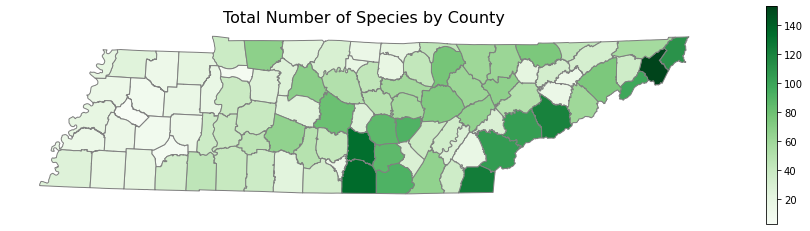

In [29]:
fig, ax = plt.subplots(figsize=(16,4))
allspec_bycounty_geo.plot(column = 'summer',
               cmap = 'Greens',
               edgecolor = 'grey',
                legend = True,
              ax = ax)
plt.title('Total Number of Species by County', fontsize = 16)
ax.axis('off');

##### Join the geometry from original watersheds file

In [30]:
allspec_bywatershed_geo = pd.merge(left = watersheds, right = allspec_bywatershed, left_on = 'HUC_8', right_on = 'Huc_8')

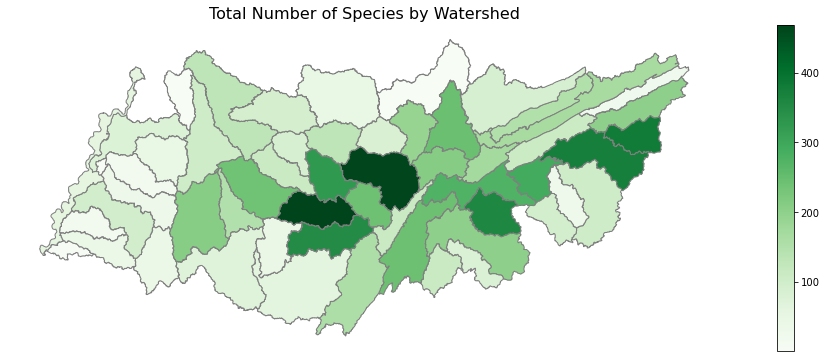

In [33]:
fig, ax = plt.subplots(figsize=(20,6))
allspec_bywatershed_geo.plot(column = 'summer',
               cmap = 'Greens',
               edgecolor = 'grey',
                legend = True,
              ax = ax)
plt.title('Total Number of Species by Watershed', fontsize = 16)
ax.axis('off');